In [1]:
import re
import netaddr
import pandas as pd
from bisect import bisect

ips = pd.read_csv("ip2location.csv")

def lookup_region(address):
    address = re.sub(r"([a-zA-Z])", "0", address)
    pattern = r'(0+)$'
    replacement = '0'
    address = re.sub(pattern, replacement, address)
    intAddress = int(netaddr.IPAddress(address))
    idx = bisect(ips["low"], intAddress)
    return ips.iloc[idx-1]["region"]

class Filing:
    def __init__(self, html):
        self.dates = []
        for i in re.findall(r"((19|20)\d{2}-(0\d|1[0-2])-(0[1-9]|1\d|2\d|3[0-1]))", html):
            self.dates.append(i[0])
        sics = re.findall(r"SIC=(\d+)", html)
        if len(sics) == 0:
            self.sic = None
        else:
            self.sic = int(sics[0])
        self.addresses = []
        for addr_html in re.findall(r"\<div class=\"mailer\"\>([\s\S]+?)\</div\>", html):
            lines = []
            for line in re.findall(r"\<span class=\"mailerAddress\"\>([\s\S]+?)\</span\>", addr_html):
                lines.append(line.strip())
            if len(lines) > 0:
                self.addresses.append("\n".join(lines))
        
    def state(self):
        for address in self.addresses:
            regex = re.findall(r"\s([A-Z]{2})\s\d{5}", address)
            if len(regex) > 0:
                return regex[0]
        return None

/tmp/ipykernel_1452739/2246760492.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import zipfile
from io import TextIOWrapper
import csv
# import edgar_utils as eu
from graphviz import Graph, Digraph
import geopandas as gpd
import re
from shapely.geometry import Point, Polygon, box

In [3]:
#Q1
zf = zipfile.ZipFile("server_log.zip")
f = zf.open("rows.csv")
df = pd.read_csv(f)
int(df["size"].sum())

24801002666

In [4]:
#Q2
df["ip"].value_counts().nlargest(20).to_dict()

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527,
 '172.250.17.bji': 3346,
 '54.212.94.jcd': 3240,
 '218.50.187.afh': 2958,
 '104.197.32.ihd': 2627,
 '49.77.196.cef': 2586,
 '216.15.11.hgb': 2524,
 '99.238.177.hec': 2400,
 '108.39.205.jga': 2325,
 '184.56.154.iah': 2188,
 '210.115.177.bch': 2183}

In [5]:
#Q3
statusCodes = df["code"].value_counts().to_dict()
total = 0
for i in statusCodes:
    if i >= 400:
        total += statusCodes[i]
total/df["code"].value_counts().sum()

0.03466852724527611

In [6]:
#Q4
def getFile(row):
    return str(int(row["cik"])) + "/" + str(row["accession"]) + "/" + str(row["extention"])

df["file"] = df.apply(lambda row: getFile(row), axis=1)
list(df["file"].value_counts().nlargest(1).to_dict().keys())[0]

'1627631/0001627631-15-000004/.txt'

In [7]:
#Q5
x = df["ip"].value_counts().to_dict()
y = max(x, key=x.get)
lookup_region(y)

'United States of America'

In [8]:
#Q6

zf = zipfile.ZipFile("server_log.zip")
f = zf.open("rows.csv")
df1 = pd.read_csv(f)
data = df1["ip"].value_counts().to_dict()
ans = {}
total = {}
for i in data:
    country = lookup_region(i)
    if(data[i] > 800):
        ans[country] = 1 + ans.get(country, 0)
    total[country] = 1 + total.get(country, 0)
finalAns = {}
for k in total:
    finalAns[k]= ans.get(k, 0)/total[k]
finalAns

{'United States of America': 0.025974025974025976,
 'China': 0.006864988558352402,
 'India': 0.058823529411764705,
 'United Kingdom of Great Britain and Northern Ireland': 0.06666666666666667,
 'Korea (Republic of)': 0.2,
 'Canada': 0.03571428571428571,
 'France': 0.0036900369003690036,
 'Bulgaria': 0.3333333333333333,
 'Ireland': 0.625,
 'Australia': 0.07692307692307693,
 'Hong Kong': 0.0,
 'Germany': 0.0,
 'Czechia': 0.0,
 'Estonia': 0.0,
 'Viet Nam': 0.0,
 'Poland': 0.0,
 'Netherlands': 0.0,
 '-': 0.0,
 'Slovakia': 0.0,
 'Russian Federation': 0.0,
 'Spain': 0.0,
 'Indonesia': 0.0,
 'Ukraine': 0.0,
 'Croatia': 0.0,
 'Italy': 0.0,
 'Taiwan (Province of China)': 0.0,
 'Virgin Islands (British)': 0.0,
 'Liberia': 0.0,
 'Singapore': 0.0,
 'Denmark': 0.0,
 'Romania': 0.0,
 'Luxembourg': 0.0,
 'Switzerland': 0.0,
 'Israel': 0.0,
 'Philippines': 0.0,
 'Egypt': 0.0,
 'Brazil': 0.0,
 'Honduras': 0.0,
 'Greece': 0.0,
 'Sweden': 0.0,
 'Japan': 0.0,
 'Cyprus': 0.0,
 'Latvia': 0.0,
 'Thailand': 0

In [9]:
#Q7
filingDict = {}
zf = zipfile.ZipFile("docs.zip")
for i in zf.filelist:
    if (i.filename.endswith("html") or i.filename.endswith("htm")):
        f = zf.open(i.filename, 'r')
        contents = f.read()
        f.close()
        filingDict[i.filename] = Filing(str(contents))

filingDict["850693/0000850693-07-000159/-index.htm"].dates

['2007-07-25', '2007-07-25', '2007-07-23']

In [10]:
#Q8
statesDistribution = {}
for i in filingDict:
    state = filingDict[i].state()
    if state != None:
        if state in list(statesDistribution.keys()):
            statesDistribution[state] += 1
        else:
            statesDistribution[state] = 1

statesDistribution

{'CA': 92,
 'NJ': 23,
 'MS': 1,
 'MA': 30,
 'CO': 25,
 'NY': 83,
 'TX': 67,
 'FL': 21,
 'AL': 1,
 'IN': 5,
 'CT': 14,
 'UT': 5,
 'MD': 13,
 'KS': 5,
 'VA': 15,
 'OH': 10,
 'SD': 1,
 'DE': 9,
 'IL': 25,
 'GA': 9,
 'NC': 9,
 'PA': 25,
 'TN': 4,
 'MN': 15,
 'NM': 1,
 'KY': 2,
 'OK': 7,
 'AR': 1,
 'NV': 6,
 'VT': 1,
 'MO': 4,
 'MI': 11,
 'NE': 2,
 'IA': 6,
 'AZ': 5,
 'WI': 9,
 'LA': 2,
 'ID': 1,
 'OR': 2,
 'WV': 2,
 'WA': 3,
 'DC': 1,
 'ME': 1}

In [11]:
#Q9
sicDistribution = {}
for i in filingDict:
    sic = filingDict[i].sic
    if sic != None:
        if int(sic) in list(sicDistribution.keys()):
            sicDistribution[int(sic)] += 1
        else:
            sicDistribution[int(sic)] = 1

sicDistribution

{2834: 40,
 6022: 20,
 1311: 20,
 6189: 17,
 6211: 17,
 8731: 2,
 1389: 19,
 7370: 7,
 3571: 1,
 7361: 1,
 3674: 5,
 4931: 5,
 1040: 2,
 2810: 2,
 7389: 11,
 3140: 1,
 7374: 4,
 6200: 1,
 7381: 1,
 3620: 3,
 3841: 6,
 4941: 1,
 5621: 1,
 7330: 1,
 6199: 8,
 6798: 20,
 2510: 4,
 3990: 2,
 1700: 5,
 7371: 6,
 5940: 2,
 4522: 5,
 1731: 2,
 6311: 2,
 8082: 2,
 2836: 13,
 6021: 20,
 1000: 11,
 4911: 8,
 6324: 2,
 8051: 1,
 6035: 4,
 3550: 1,
 4813: 4,
 6321: 2,
 2890: 1,
 3845: 2,
 2860: 8,
 1221: 2,
 3669: 2,
 6411: 1,
 5900: 2,
 2320: 1,
 6221: 3,
 6331: 10,
 2070: 1,
 8742: 5,
 3829: 3,
 900: 5,
 5500: 2,
 7372: 11,
 6770: 1,
 4841: 2,
 4833: 1,
 7384: 1,
 6799: 3,
 3826: 5,
 8711: 2,
 5160: 1,
 5944: 1,
 3420: 3,
 3510: 3,
 5960: 1,
 3842: 4,
 8062: 3,
 6029: 11,
 7320: 1,
 5172: 2,
 1382: 2,
 3663: 4,
 1400: 3,
 7822: 1,
 2024: 1,
 2080: 1,
 7812: 2,
 4922: 2,
 2030: 1,
 3576: 3,
 2711: 1,
 3578: 1,
 3679: 2,
 2842: 1,
 4899: 1,
 100: 1,
 3541: 1,
 7311: 1,
 3317: 1,
 2033: 1,
 3721: 1

In [12]:
#Q10
finalDict = {}

def addToDict(name):
    if name in list(filingDict.keys()):
        sic = filingDict[name].sic
        if sic != None:
            if int(sic) in list(finalDict.keys()):
                finalDict[int(sic)] += 1
            else:
                finalDict[int(sic)] = 1
df["file"].apply(lambda x: addToDict(x))
finalDict

{4931: 70,
 1000: 273,
 6021: 204,
 7371: 229,
 2860: 226,
 6211: 237,
 2834: 984,
 1389: 656,
 4522: 22,
 6282: 171,
 6022: 379,
 1700: 31,
 6331: 91,
 4813: 4,
 2836: 429,
 3620: 50,
 1311: 550,
 4841: 108,
 3272: 81,
 7200: 94,
 6513: 38,
 7374: 94,
 3510: 66,
 4512: 42,
 3826: 56,
 3678: 4,
 4911: 8,
 2510: 171,
 6798: 90,
 7830: 62,
 3571: 6,
 6221: 85,
 3621: 38,
 3695: 55,
 3590: 24,
 6321: 21,
 4812: 4,
 3312: 31,
 3842: 87,
 2870: 2,
 4955: 23,
 7370: 39,
 1040: 2,
 900: 39,
 4833: 7,
 6029: 83,
 3990: 34,
 5311: 90,
 5944: 33,
 3663: 23,
 8742: 27,
 5621: 99,
 8090: 32,
 4412: 43,
 8731: 25,
 7373: 48,
 8711: 2,
 6411: 3,
 3669: 2,
 5172: 36,
 3825: 164,
 3559: 20,
 2080: 1,
 3541: 1,
 7389: 26,
 2711: 1,
 7812: 25,
 7350: 1,
 1400: 3,
 5900: 35,
 3829: 73,
 5812: 19,
 3845: 2,
 6770: 2,
 3841: 14,
 7990: 1,
 2911: 1,
 6799: 46,
 1382: 2,
 3679: 5,
 3721: 1,
 5122: 34,
 5990: 1,
 1531: 4,
 5731: 1,
 5531: 1,
 6324: 30,
 2750: 1,
 4213: 35,
 1381: 31,
 2030: 1,
 3714: 1,
 7372

In [13]:
#Q11
hoursDict = {}
def addToHoursDict(time):
    hr = int(time[:2])
    if hr in list(hoursDict.keys()):
        hoursDict[hr] += 1
    else:
        hoursDict[hr] = 1
df["time"].apply(lambda x: addToHoursDict(x))
hoursDict

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

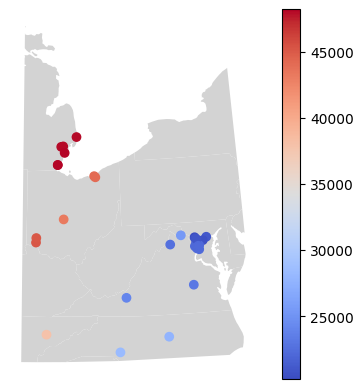

In [14]:
#Q13
path = "shapes/cb_2018_us_state_20m.shp"

locations = gpd.read_file('locations.geojson')
locations['postal_code'] = locations['address'].str.extract(r'(\d{5})').fillna('')
locations['postal_code'] = locations['postal_code'].str.split('-').str[0]
locations = locations[locations['postal_code'].str.isnumeric()]
locations['postal_code'] = locations['postal_code'].astype(int)
locations = locations[locations['postal_code'].between(20000, 80000)]

west = -85
east = -75
north = 50
south = 35
bbox = box(west, south, east, north)

us = gpd.read_file(path)
us = us.intersection(bbox)
us = us.to_crs("EPSG:2022")
ax = us.plot(color = "lightgray")
locations['intersection'] = locations.intersection(bbox)
locations = locations.to_crs("EPSG:2022")

filtered_df = locations[locations['intersection'].astype(str) != "POINT EMPTY"]
filtered_df.plot(ax = ax, column = 'postal_code', legend = True, cmap = "coolwarm")
ax.set_axis_off()